In [1]:
import numpy as np
from scipy.stats import skewnorm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from tqdm.notebook import tqdm

In [2]:
def costFn(params, z_params):
    alpha, omega, loc = params
        
    dist = skewnorm(alpha, scale=omega, loc=loc)

    # Calculate the CDF at points a, b, and c
    cdf_a = dist.cdf(z_params[1])
    cdf_b = dist.cdf(z_params[0])
    cdf_c = dist.cdf(z_params[2])
    
    # The areas we want to match
    area_left = cdf_b - cdf_a
    area_right = cdf_c - cdf_b
    
    # Objective is to make both areas equal to 0.34
    return (area_left - 0.34)**2 + (area_right - 0.34)**2 + (dist.median()-z_params[0])**2

In [3]:
def fit_Plot(af, wf, lf, zmed, l68, u68, plot_path, cid):

    dist = skewnorm(af, scale=wf, loc=lf)
    rvs = dist.rvs(10000)

    delta =af / np.sqrt(1 +af**2)
    gamma = (4-np.pi)/2 * (delta*np.sqrt(np.pi/2))**3 / (1-2*delta**2/np.pi)**1.5
    mu = dist.mean()
    final_med = dist.median()

    # Final skew-normal distribution
    p_l68 = dist.cdf(zmed) - dist.cdf(l68)
    p_u68 = dist.cdf(u68) - dist.cdf(zmed)
    xs = np.linspace(zmed-3*(zmed-l68), zmed+3*(u68-zmed), 1000)
    plt.figure(figsize=(7, 5))
    plt.title(rf"C20 ID = {int(cid)}    $\alpha$={round(af, 2)}       $\omega$={round(wf, 2)}      $\xi$={round(lf, 2)}    $\gamma$={round(gamma, 2)}")
    plt.hist(rvs, density=True, bins=100, label=f"N = {10000} draws", alpha=0.75)
    plt.plot(xs, dist.pdf(xs))
    plt.vlines(mu, ymin=0, ymax=2, color='red', label=f"Mean = {round(mu, 3)}")
    plt.vlines(final_med, ymin=0, ymax=2, color='orange', label=f"Median = {round(final_med, 3)}    ({zmed})")
    plt.vlines(l68, ymin=0, ymax=1, color='g', label=f"Lower-bound  ({round(p_l68,3)})")
    plt.vlines(u68, ymin=0, ymax=1, color='m', label=f"Upper-bound  ({round(p_u68, 3)})")
    plt.legend()
    plt.savefig(plot_path)
    plt.close()

def show_Plot(af, wf, lf, zmed, l68, u68, cid):

    dist = skewnorm(af, scale=wf, loc=lf)
    rvs = dist.rvs(10000)

    delta =af / np.sqrt(1 +af**2)
    gamma = (4-np.pi)/2 * (delta*np.sqrt(np.pi/2))**3 / (1-2*delta**2/np.pi)**1.5
    mu = dist.mean()
    final_med = dist.median()

    # Final skew-normal distribution
    p_l68 = dist.cdf(zmed) - dist.cdf(l68)
    p_u68 = dist.cdf(u68) - dist.cdf(zmed)
    xs = np.linspace(zmed-3*(zmed-l68), zmed+3*(u68-zmed), 1000)
    plt.figure(figsize=(7, 5))
    plt.title(rf"C20 ID = {int(cid)}    $\alpha$={round(af, 2)}       $\omega$={round(wf, 2)}      $\xi$={round(lf, 2)}    $\gamma$={round(gamma, 2)}")
    plt.hist(rvs, density=True, bins=100, label=f"N = {10000} draws", alpha=0.75)
    plt.plot(xs, dist.pdf(xs))
    plt.vlines(mu, ymin=0, ymax=2, color='red', label=f"Mean = {round(mu, 3)}")
    plt.vlines(final_med, ymin=0, ymax=2, color='orange', label=f"Median = {round(final_med, 3)}    ({zmed})")
    plt.vlines(l68, ymin=0, ymax=1, color='g', label=f"Lower-bound  ({round(p_l68,3)})")
    plt.vlines(u68, ymin=0, ymax=1, color='m', label=f"Upper-bound  ({round(p_u68, 3)})")
    plt.legend()
    plt.show()

In [4]:
def fitDist(zmed, l68, u68, plot_path = "", cid = None):
    
    wi = 2/3*(u68 - l68)    # Initial omega
    var = ((zmed-l68)**2 + (u68-zmed)**2)/2     # variance estimate
    d = np.sqrt(  np.pi/2 * (1-var/wi**2))      # Delta parameter

    if (zmed - l68) < (u68-zmed):
        li = l68 -wi/4
        ai = 50*var**0.5
    else:
        li = u68 + wi/4
        ai = -50*var**0.5

    # Initial guess for omega and alpha
    initial_guess = [ai, wi, li]

    # Minimize the objective function
    result = minimize(costFn, initial_guess, tol=1e-14, options={'maxiter':100},
                    args=([zmed, l68, u68]), bounds = ((-12, 12), (0,5), (0,7)))
    
    af, wf, lf = result.x   # Optimized parameters
    residual = costFn(result.x, [zmed, l68, u68])

    if plot_path != "": fit_Plot(af, wf, lf, zmed, l68, u68, plot_path, cid)

    return af, wf, lf, residual

---
---
---
---


# Load Data


In [5]:
cosmos_file = fits.open(r"C:/Users/sikor/OneDrive/Desktop/BigData/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0.fits")
c20p = cosmos_file[1].data

zmeds = c20p['lp_zPDF']
l68s = c20p['lp_zPDF_l68']
u68s = c20p['lp_zPDF_u68']


In [6]:
pdf_file = fits.open(r"C:\Users\sikor\OneDrive\Desktop\BigData\COSMOS2020\COSMOS2020_CLASSIC_R1_v2.2_LEPHARE_PZ_p3.fits")
pdf_zs = pdf_file[0].data[0][1:]
c20_pdfs = pdf_file[0].data[1:]

---
---
---
---


# Finding Bad Fits

Load the old fits. They have the formats:

[Cosmos ID, Scale (alpha), width (omega), location (median-ish), residual]

In [7]:
Pfits = np.load('zFits/zFits.npy')
print('Shape = ', Pfits.shape)
print(Pfits[:10])

Shape =  (99999, 5)
[[ 3.33895000e+05 -1.21533722e+00  4.35893632e-01  2.48810017e+00
   2.94280166e-15]
 [ 3.33946000e+05 -1.20000000e+01  1.18923224e+00  3.16630913e+00
   7.98611843e-05]
 [ 3.33976000e+05 -2.19895848e+00  2.50199916e-01  2.62292210e+00
   2.29273201e-15]
 [ 3.34047000e+05 -1.05651240e+00  2.51354034e-01  3.24465851e+00
   1.39992416e-14]
 [ 3.34067000e+05  8.39177583e-01  1.31942488e-01  1.80847675e+00
   4.64918459e-16]
 [ 3.34169000e+05 -2.99988170e+00  5.54920864e-01  2.57440314e+00
   7.21837828e-16]
 [ 3.34210000e+05 -3.31081430e+00  2.70684538e-01  2.72243119e+00
   9.68943692e-16]
 [ 3.34230000e+05 -4.93343327e+00  1.94085866e-01  2.09430460e+00
   1.28070602e-15]
 [ 3.34238000e+05 -2.26639950e+00  2.46690996e-01  2.94160032e+00
   1.62771194e-15]
 [ 3.34303000e+05 -5.51491945e+00  3.95162182e-01  3.87213119e+00
   4.77484213e-16]]


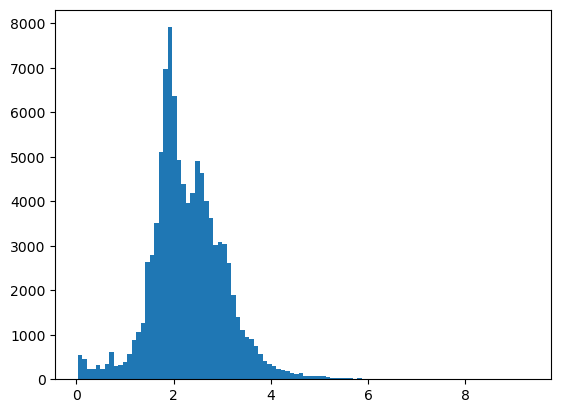

In [8]:
zs = c20p["lp_zPDF"][Pfits[:,0].astype(int) -1]

plt.hist(zs, bins = 100)
plt.show()

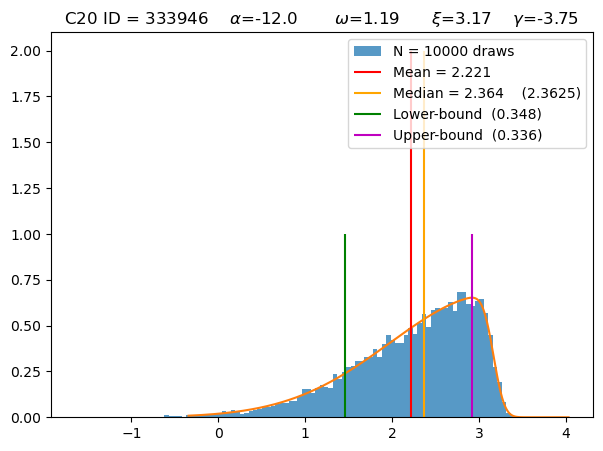

In [9]:
fit_ps = Pfits[1]
cid = int(fit_ps[0] -1)
show_Plot(*fit_ps[1:4],zmeds[cid], l68s[cid], u68s[cid], cid+1)

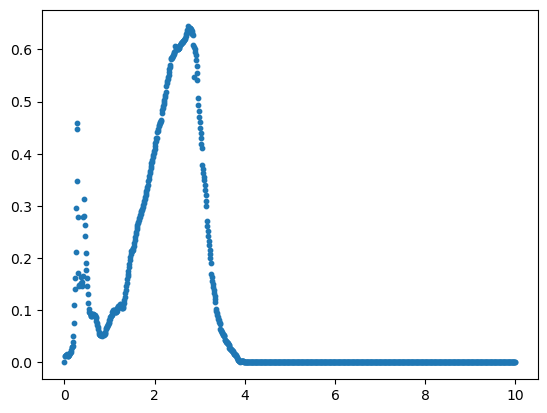

In [10]:
plt.scatter(pdf_zs, c20_pdfs[cid][1:], s=10)

In [11]:
def Save_Plot(af, wf, lf, zmed, l68, u68, plot_path, cid):

    dist = skewnorm(af, scale=wf, loc=lf)
    rvs = dist.rvs(10000)

    delta =af / np.sqrt(1 +af**2)
    gamma = (4-np.pi)/2 * (delta*np.sqrt(np.pi/2))**3 / (1-2*delta**2/np.pi)**1.5
    mu = dist.mean()
    final_med = dist.median()

    # Final skew-normal distribution
    p_l68 = dist.cdf(zmed) - dist.cdf(l68)
    p_u68 = dist.cdf(u68) - dist.cdf(zmed)
    xs = np.linspace(max(zmed-3*(zmed-l68), 0), zmed+3*(u68-zmed), 1000)
    plt.figure(figsize=(7, 5))
    plt.title(rf"C20 ID = {int(cid)}    $\alpha$={round(af, 2)}       $\omega$={round(wf, 2)}      $\xi$={round(lf, 2)}    $\gamma$={round(gamma, 2)}")
    plt.hist(rvs, density=True, bins=100, label=f"N = {10000} draws", alpha=0.75)
    plt.plot(xs, dist.pdf(xs))
    plt.vlines(mu, ymin=0, ymax=2, color='red', label=f"Mean = {round(mu, 3)}")
    plt.vlines(final_med, ymin=0, ymax=2, color='orange', label=f"Median = {round(final_med, 3)}    ({zmed})")
    plt.vlines(l68, ymin=0, ymax=1, color='g', label=f"Lower-bound  ({round(p_l68,3)})")
    plt.vlines(u68, ymin=0, ymax=1, color='m', label=f"Upper-bound  ({round(p_u68, 3)})")

    plt.scatter(pdf_zs, c20_pdfs[cid-1][1:], color='r', label='COSMOS P(z)')

    plt.legend()

    plt.xlim(max(zmed-3*(zmed-l68), 0), min(10, zmed+3*(u68-zmed)))

    plt.savefig(plot_path)
    plt.close()

In [12]:
for fit_ps in Pfits[:100]:

    cid = int(fit_ps[0])
    plot_path = f'pdf_test/c20_{cid}.png'
    Save_Plot(*fit_ps[1:4],zmeds[cid-1], l68s[cid-1], u68s[cid-1],plot_path, cid)

In [13]:
cid = 333976 -1


pdf_values = c20_pdfs[cid][1:]


3.338909


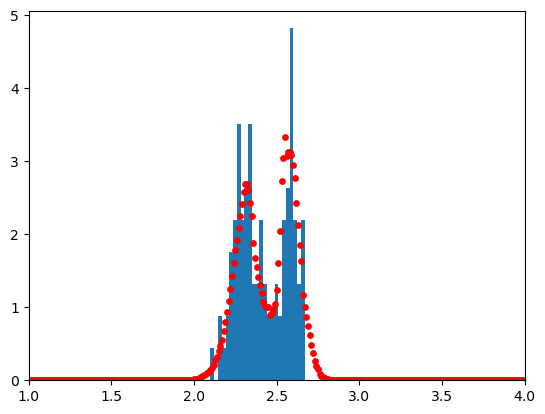

In [14]:
cid = 333976 -1

pdf_values = c20_pdfs[cid][1:]
# Example data: x points and their corresponding PDF values (not normalized)
print(pdf_values.max())

# Step 2: Draw random samples based on the PDF
n_samples = 100
samples = np.random.choice(pdf_zs, size=n_samples, p=pdf_values/pdf_values.sum())

plt.hist(samples, bins=25, density=True)
plt.scatter(pdf_zs, pdf_values, c='r', s=15)
plt.xlim(1,4)
plt.show()

In [15]:
Pfits[:,0][:10]

array([333895., 333946., 333976., 334047., 334067., 334169., 334210.,
       334230., 334238., 334303.])

In [16]:
from scipy.stats import ks_2samp
cid =  333895 -1

af, wf, lf = Pfits[0][1:4]

# Your data
pdf_values = c20_pdfs[cid][1:] / sum(c20_pdfs[cid][1:])  # Your PDF values (assume normalized so they sum to 1)
x_values = pdf_zs  # x-axis values corresponding to pdf_values

# Convert PDF to CDF
cdf_values = np.cumsum(pdf_values)

# Generate sample data from this distribution
cdf_sample = np.interp(np.random.rand(1000), cdf_values, x_values)  # Generate 1000 random samples

# Your random values to compare
dist = skewnorm(af, scale=wf, loc=lf)
sample_data = dist.rvs(100000)  # Replace with your sample data

# Perform KS test
ks_statistic, p_value = ks_2samp(sample_data, cdf_sample)

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret results
if p_value < 0.05:
    print("The two distributions are statistically different.")
else:
    print("No significant difference between the distributions.")


KS Statistic: 0.041580000000000006
P-value: 0.06339450693135995
No significant difference between the distributions.


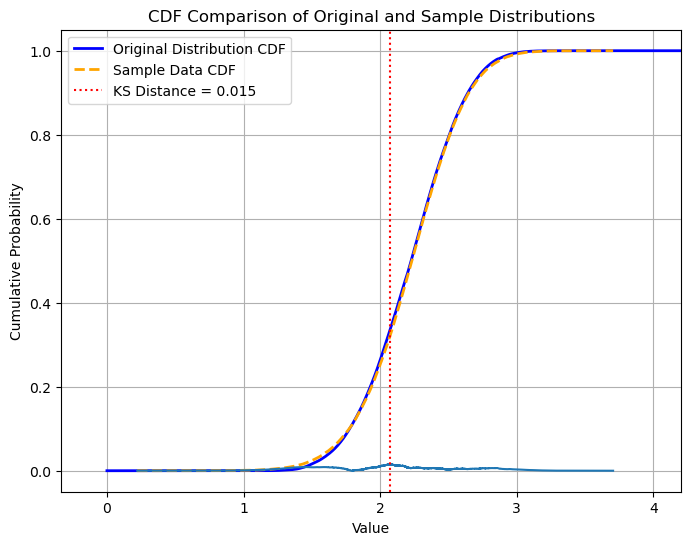

In [17]:
import matplotlib.pyplot as plt

# Calculate the CDF of your PDF data
cdf_values = np.cumsum(pdf_values)
cdf_values /= cdf_values[-1]  # Normalize to make sure the CDF goes from 0 to 1

# Generate the empirical CDF of your sample data
sample_data_sorted = np.sort(sample_data)
sample_data_cdf = np.arange(1, len(sample_data_sorted) + 1) / len(sample_data_sorted)

# Interpolate the original CDF at the sample data points
original_cdf_at_sample = np.interp(sample_data_sorted, x_values, cdf_values)

# Calculate the KS distance and find the location of the maximum difference
cdf_differences = np.abs(original_cdf_at_sample - sample_data_cdf)
ks_distance = np.max(cdf_differences)
ks_location = sample_data_sorted[np.argmax(cdf_differences)]

# Plot the CDFs
plt.figure(figsize=(8, 6))
plt.plot(x_values, cdf_values, label="Original Distribution CDF", color="blue", lw=2)
plt.plot(sample_data_sorted, sample_data_cdf, label="Sample Data CDF", color="orange", linestyle="--", lw=2)
plt.plot(sample_data_sorted, cdf_differences)

# Add KS statistic marker (maximum distance)
plt.axvline(ks_location, color="red", linestyle=":", label=f"KS Distance = {ks_distance:.3f}")
plt.xlim(-1/3, max(sample_data_sorted)+0.5)
# Labels and legend
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.title("CDF Comparison of Original and Sample Distributions")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
def KS_test(skew_fit, draws, plot_path=None):
    
    # Unpack skew-fit info
    cid =  int(skew_fit[0]) - 1
    af, wf, lf = skew_fit[1:4]

    # Your data
    pdf_values = c20_pdfs[cid][1:] / sum(c20_pdfs[cid][1:])  # Your PDF values (assume normalized so they sum to 1)
    x_values = pdf_zs  # x-axis values corresponding to pdf_values

    # Convert PDF to CDF
    cdf_values = np.cumsum(pdf_values)

    # Generate sample data from this distribution
    cdf_sample = np.interp(np.random.rand(1000), cdf_values, x_values)  # Generate 1000 random samples

    # Your random values to compare
    dist = skewnorm(af, scale=wf, loc=lf)
    sample_data = dist.rvs(draws)  # Replace with your sample data

    # Perform KS test
    ks_statistic, p_value = ks_2samp(sample_data, cdf_sample)

    if plot_path != None:
    # Calculate the CDF of your PDF data
        cdf_values = np.cumsum(pdf_values)
        cdf_values /= cdf_values[-1]  # Normalize to make sure the CDF goes from 0 to 1

        # Generate the empirical CDF of your sample data
        sample_data_sorted = np.sort(sample_data)
        sample_data_cdf = np.arange(1, len(sample_data_sorted) + 1) / len(sample_data_sorted)

        # Interpolate the original CDF at the sample data points
        original_cdf_at_sample = np.interp(sample_data_sorted, x_values, cdf_values)

        # Calculate the KS distance and find the location of the maximum difference
        cdf_differences = np.abs(original_cdf_at_sample - sample_data_cdf)
        ks_distance = np.max(cdf_differences)
        ks_location = sample_data_sorted[np.argmax(cdf_differences)]

        # Plot the CDFs
        # plt.figure(figsize=(8, 6))
        # plt.plot(x_values, cdf_values, label="Original Distribution CDF", color="blue", lw=2)
        # plt.plot(sample_data_sorted, sample_data_cdf, label="Sample Data CDF", color="orange", linestyle="--", lw=2)
        # plt.plot(sample_data_sorted, cdf_differences, color='red', label="CDF Abs. Differences")

        # # Add KS statistic marker (maximum distance)
        # plt.axvline(ks_location, color="green", linestyle=":", label=f"KS Distance = {ks_distance:.3f}")
        # plt.xlim(-1/3, max(sample_data_sorted)+0.5)

        # # Labels and legend
        # plt.xlabel("Value")
        # plt.ylabel("Cumulative Probability")
        # title_p = "{:.3g}".format(p_value)

        # if p_value < 0.05:
        #     plt.title(f"These Are Different Samples      (p = {title_p})")
        # else:
        #     plt.title(f"These Are Identical Samples      (p = {title_p})")
        # plt.legend()
        # plt.grid(True)
        # plt.savefig(plot_path)
        # plt.close()

    return p_value, ks_distance

In [19]:
p_vals = []

for _ip, p in tqdm(enumerate(Pfits), total=len(Pfits)):

    if _ip < 100:
        pv = KS_test(p, 100, plot_path=f'KS_Tests/c20_{int(p[0])}.png')
    else:
        pv = KS_test(p, 100)

    p_vals.append(pv)

  0%|          | 0/99999 [00:00<?, ?it/s]

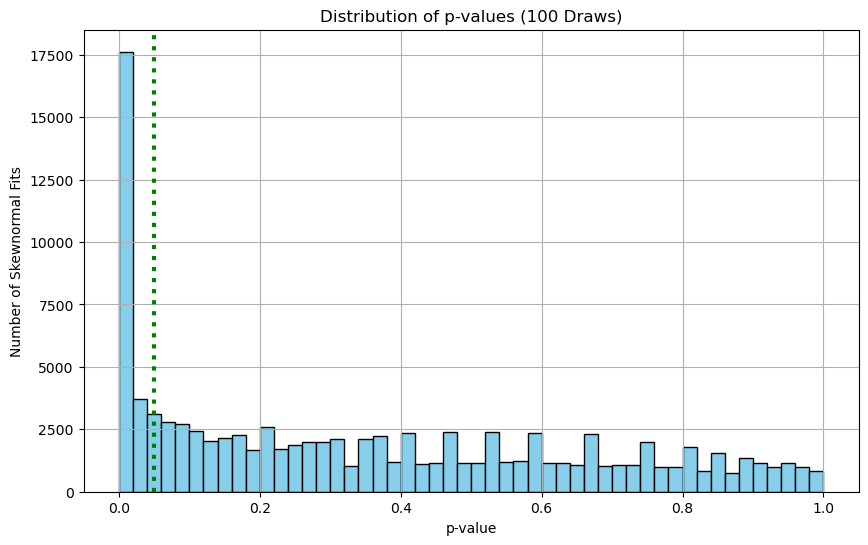

In [28]:
# Assuming `p_values` is a list or array of your 100,000 p-values
plt.figure(figsize=(10, 6))
plt.hist(p_vals, bins=50, color="skyblue", edgecolor="black")
plt.axvline(0.05, 0, 1, ls=':', c='g', lw=3)
plt.xlabel("p-value")
plt.ylabel("Number of Skewnormal Fits")
plt.title("Distribution of p-values (100 Draws)")
plt.grid(True)
plt.show()


In [35]:
len(np.where(np.array(p_vals) < 0.05)[0]) / len(p_vals)

0.23178231782317824

In [23]:
ksd = []
pvs = []

for _ip, p in tqdm(enumerate(Pfits), total=len(Pfits)):

    pv, kd = KS_test(p, 10000, plot_path=f'')

    ksd.append(kd)
    pvs.append(pv)

  0%|          | 0/99999 [00:00<?, ?it/s]

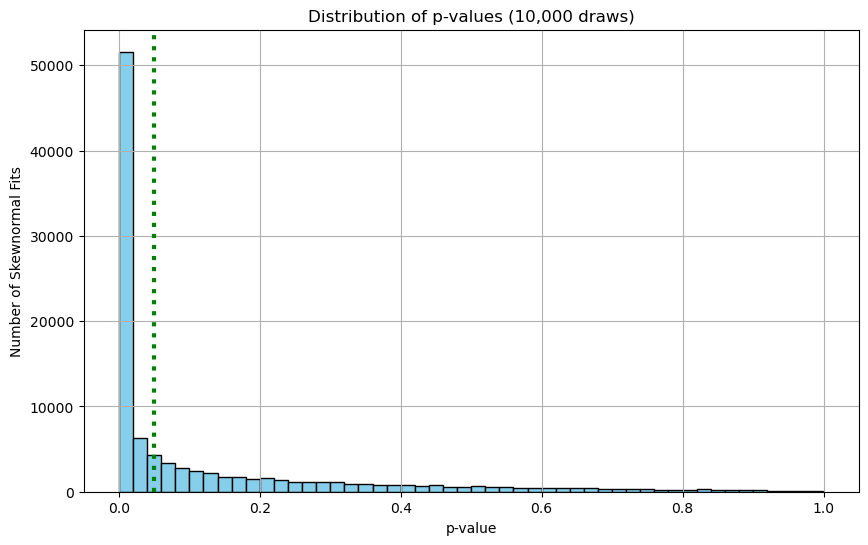

In [29]:
# Assuming `p_values` is a list or array of your 100,000 p-values
plt.figure(figsize=(10, 6))
plt.hist(pvs, bins=50, color="skyblue", edgecolor="black")
plt.axvline(0.05, 0, 1, ls=':', c='g', lw=3)
plt.xlabel("p-value")
plt.ylabel("Number of Skewnormal Fits")
plt.title("Distribution of p-values (10,000 draws)")
plt.grid(True)
plt.show()


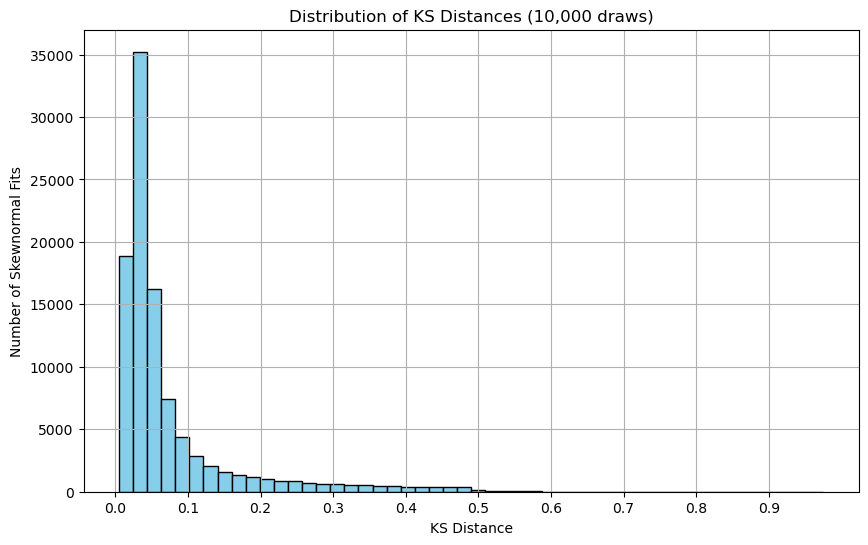

In [30]:
# Assuming `p_values` is a list or array of your 100,000 p-values
plt.figure(figsize=(10, 6))
plt.hist(ksd, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("KS Distance")
plt.ylabel("Number of Skewnormal Fits")
plt.title("Distribution of KS Distances (10,000 draws)")
plt.xticks(np.arange(0,1,0.1))
plt.grid(True)
plt.show()
